# Introduction:

This notebook is to summarizes the practical steps taken in linear regressions. I tried to be as generic as possible. But of course, each dataset has its unique characteristics that need extra, or fewer, steps. So if you see any missing or unnecessary steps unnecessary don't hesitate to leave a comment :) 

I'm going to refere to the dependent variable as $y$, and the independent variables (features) as $x ~ (x_1, x_2\dots x_n)$. With that out of the way, let me list steps as follows:
1. Ask the right question
2. Read the data: 
 - Examine data types, look for any missing values, outliers, and imbalance (across $y$ and $x$) in the set
 - Scatter plot $y,x$: this will help spot the relationship between them 
 - Plot histograms $y,x$: will help to know what to expect 
3. Based on the spotted relationship, decide which model to use (linear, log-linear, quadratic..etc). Try to answer the following questions:
 - What values can $y$ take (positive, negative, and zero)?
 - What should the signs of the coefficients look like (positive, negative)?
4. Build the model and examine results:
 - Are the coefficients statistically significant?
 - Do they have the signs you'd expected?
 - Make sense of the coefficients irrespective of their significance and adjust if needed. **For example**: ask the question does the sign/value/p-value of a coefficient make economic sense?
5. Now that you've built the model and adjusted parameters, run a goodness-of-fit. This is to make sure the model doesn't violate any of the assumptions of linear regressions (4.1 for details) :
 - Linearity
 - Independence (of $x$): is there a multicollinearity
 - Homoscadasticity of $\epsilon$: Breusch–Pagan Test for homoskedasticity.
 - No autocorrelation of $\epsilon$: Durbin-Watson Test 
 - Normality of $\epsilon$: Shapiro-Wilk Test for normality,Q-Q plot, histogram 
6. Now that the model is valid. The residuals follow normal distribution with a constant variance. And they are independent of and not serially correlated. We can predict values and calculate their intervals. We will set aside a slice of the data for this purpose, or we can use makeup data! Always make sure the predictions make economic sense 
 

# 1. Ask the Right Question:
   
The first and most important step in data analysis is to ask the right question. Here, the question is: is there a linear relationship between (Height,Gender) and Weight. If Yes, build a model to reference it, validate this model, interpret results and make predictions.

# 2. Data Collection:

The second step is collecting data. Here we're using simple Bivariate dataset that contains Weights - in lbs- and Heights -in inches- of 10,000 observations, represents Males and Femals adulst. I suppose was taken randomly!

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
from statsmodels.stats import diagnostic

%matplotlib inline

plt.style.use('default')
import os
path = '~/workspace/RegressionTests/lib/data/weight-height.csv'
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


df = pd.read_csv(path)
df.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


# 2. Read & Clean the Data:
The set is a simple Bivariate that contains Weights - in lbs- and Heights -in inches- of 10,000 observations representing Male and Female adulst. I suppose it was taken at random!
   
### 2.1 Missing Values (N/A):
Examine the data for any missing values in $x, y$. And if you find any either drop the missing record or fill it with its closest match

In [2]:
print(df.isna().sum())

Gender    0
Height    0
Weight    0
dtype: int64


**Conclusion:** the data is not missing any values.

### 2.2 Outliers

Sometimes outliers are bad data that you must get rid of, but sometimes they're Michael Jordan or Shaquille O'Neal and you must keep. Either way, you must identify outliers.  
To do that, let's define them as observations that are: 
1. More than 3 standard deviations away from the mean.
2. Or more than 1.5 * Inter-Quartile-Range (IQR) below/above the 25th/75th percentiles (ends of the boxplot).

Current data contains one continuous and one categorical (discrete) variables. A simple boxplot should do just fine visualizing them.  

**More on outliers detection**   
The most common tecniques used to identify outliers by data types is:  
- Univariate data -> boxplot. outside of 1.5 times inter-quartile range is an outlier.  
- Bivariate -> scatterplot with confidence ellipse. outside of, say, 95% confidence ellipse is an outlier.  
- Multivariate -> Mahalanobis D2 distance   

Once defined, mark those observations as outliers. Then run a logistic regression to see if there are any systematic patterns.   

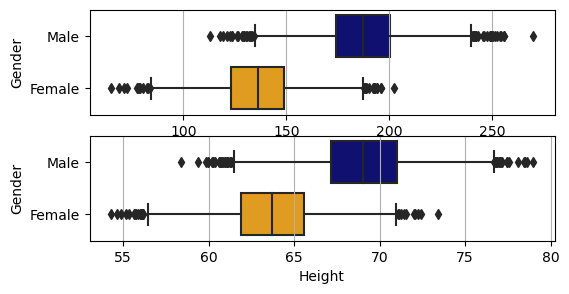

In [3]:
# Outliers: 
palette=['navy','orange']
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(6,3))
ax1.grid()
# ax1.boxplot(data=df, x=['Weight'])
sns.boxplot(x=df.Weight, y=df.Gender, ax=ax1, palette=palette)
ax2.grid()
sns.boxplot(x=df.Height, y=df.Gender, ax=ax2, palette=palette);

I don't see why a 270 lbs male or a 55 inch female must be excluded from the study. Therefore, I'm going to leave the dataset as-is
### 2.3 Balacend

In general, having balanced data generates higher accuracy models. This is true for all regression types and machine learning algorithms.  

In [4]:
# 3. Distribution across genders is perfect
pd.value_counts(df.Gender)

Male      5000
Female    5000
Name: Gender, dtype: int64

Looks like the data is split equally between Male and Female. Which is ideal!.  

*Note: use WLS (weighted least squared regression) instead of OLS when dealing with imbalanced data.*

### 2.4 Scatter plot x,y

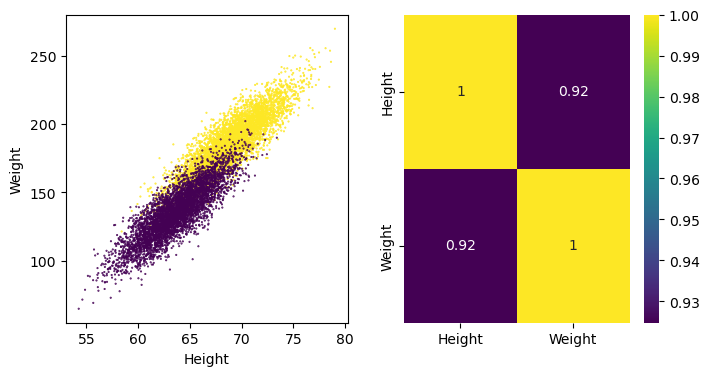

In [5]:
fig,ax = plt.subplots(1,2, figsize=(8,4))
ax[0].scatter(df.Height, df.Weight, c=df.Gender=='Male',marker='.',s=1)
ax[0].set_xlabel('Height')
ax[0].set_ylabel('Weight')
sns.heatmap(df.corr(), annot=True, ax=ax[1],cmap='viridis');

### 2.5 Distribution of Variables (Optional)
The dependent and/or independent variables don't need to be Normal distributed. Yet, if their distributions are extremely off normal, it's difficult to fit a line that results in normal errors. Which is one of the assumptions of linear regression 3.1.6. 
I usually check the distribution of all variables upfront to know what to expect. This is an optional but helpful step.  

The easiest way to do that in practice is to visualize the distribution using histogram (across categories):

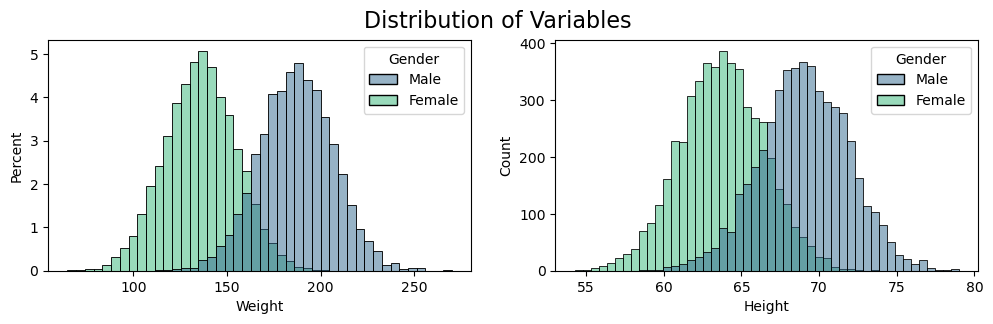

In [6]:
fig,ax = plt.subplots(1,2,figsize=(12,3))
fig.suptitle('Distribution of Variables', fontsize=16)
sns.histplot(data=df, x='Weight', hue='Gender', ax=ax[0], stat='percent', palette='viridis')
sns.histplot(data=df, x='Height', hue='Gender',ax=ax[1], palette='viridis');

Seems like both variables are normally distributed. This will make our life easier when investigating some of the typical problems of linear regressions. 

## 3. Analyzing the Data

This step should answer the question asked in step (1). i.e. is there a linear relationship between the dependent and independent variables?  That said, let's list the assumptions of linear regression:
### 3.1 Assumptions of a Linear Regression

1. There is a linear relationship between dependent and independent variables
2. The independent variables are not random, and there is no exact linear relationship between them. (no multicollinearity)
3. The expected value of error term is zero $E(\epsilon | x_i)=0$
4. The variance of the error term is constant for all observations (i.e. $E(\epsilon^2_i)=\sigma_{\epsilon}^2$ (no heteroscedasticity)
5. The error term of one observation is not correlated with that of another (no serial correlation)
6. The error term is normally distributed

We are going to test each of these assumptions after regressing the data  


### 3.2 Pre-Processing
#### 3.2.1 Split the Data

It's standard practice to split the data into training and test sets to see how the model behaves when presented with data it hasn't seen. I'm going to use pandas to do this. 

Another, very common way to do it is by using`train_test_split` from `sklearn.model_selection`, but I prefer pandas. As it retains both sets as DataFrames. This will make the regression outcome much more user-friendly!  


In [7]:
# Split the data to train and test using pandas

df_test = df.sample(frac=0.3)
df_train = pd.merge(df, df_test, how='outer', indicator=True).query('_merge =="left_only"').drop(columns=['_merge'])
print(f'Size of training set:{len(df_train)}, size of test set: {len(df_test)}\n')

Size of training set:7000, size of test set: 3000



#### 3.2.2 Balance Re-Check

To make sure splitting the data didn't affect the balance of observations:

In [8]:
print("Gender count across Train Set:\n",pd.value_counts(df_train.Gender))

Gender count across Train Set:
 Male      3507
Female    3493
Name: Gender, dtype: int64


### 3.3 OLS regression model

In [9]:
# Ordinary Least Square (OLS) regression
ols = smf.ols(formula="Weight ~ C(Gender) + Height", data=df_train)
res = ols.fit(cov_type='nonrobust')
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                 3.233e+04
Date:                Sat, 23 Oct 2021   Prob (F-statistic):               0.00
Time:                        10:15:22   Log-Likelihood:                -26067.
No. Observations:                7000   AIC:                         5.214e+04
Df Residuals:                    6997   BIC:                         5.216e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          -246.5328      2.72

## 4. Interpreting Regression Results

Adj. R-Squared value at 0.902 and Prob(F-statistic) at 3.2e+4, tell that the model is doing a good job explaining the varibility in indepent variable. The coefficents have high t-values and zero associated p-values indicating statistical significane.  


### 4.1 Is the Model Valid?

To answer this question we need to make sure the model does not violate any of the assumptions in 4.1, So let's group them and sort them from most to least serious.  


### 4.1.1 Violations of linearity (Extremely Serious)

**First:** Check the correlation between dependent and independent variables. The table below shows strong positive association between Height and Weight across Genders. Which supports linearity in our case (be carefull when using correlation in higher dimensions as it could be misleading)   

**Second:**  
Plot predicted vs observed: the points should be symmetrically distributed around a diagonal line (figure 1)  
Plot predicted vs residuals: the points should be symmetrically distributed around a horizontal line (figure 2)  

In [10]:
#Correlation between Hieght and Weight across Genders
print("Corrolation table:\n", df_train.groupby('Gender').corr().Height.to_frame().loc[(slice(None),["Weight"]),])

Corrolation table:
                  Height
Gender                 
Female Weight  0.852124
Male   Weight  0.866229


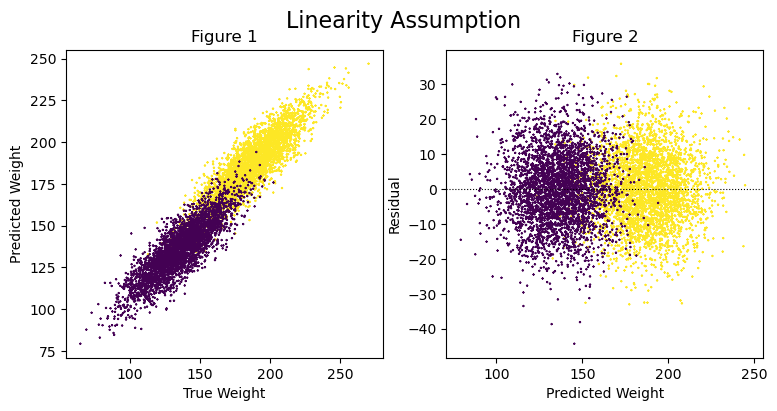

In [11]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(9,4), squeeze=True)
fig.suptitle("Linearity Assumption", fontsize=16)
ax1.scatter(x=df_train.Weight, y=res.predict(), c=df_train.Gender=='Male', s=0.65, marker='x')
ax1.set_title('Figure 1')
ax1.set_xlabel('True Weight')
ax1.set_ylabel('Predicted Weight')
ax2.scatter(x=res.predict(), y= res.resid, c=df_train.Gender=='Male', s=0.65, marker='x')
ax2.set_title('Figure 2')
ax2.set_xlabel('Predicted Weight')
ax2.set_ylabel('Residual')
ax2.axhline(0,lw=0.8,c='k',ls=':')
plt.show()

Our model appears to be linear.

### 4.1.2 Violation of Independence (Multicollinearity):
"The independent variables are not random and thers is no exact linear relationship between them".  
Typically spotted when t-tests indicates non of the individual coefficients is significant **while** R-squared and F-statistics are high. We don't have this here.  
It can also be present if the **Condition Number** is large, which it is here, but we can ignore this since we have only one continuous variable

### 4.1.3 Violations of Homoscedasticity:
Heteroskedasticity occures when the variance of the residuals is not constant across observations. There are two methods to detect heteroskedasticity: examining scatter plots of the residuals
and using the Breusch-Pagan chi-square $\chi^2$ test.

Visually, scatter plot **residuals vs. predicted** and **residuals vs. one or more independent** varialbe. And look for pattens where residuals grow/shrink as function of predicted values (or time in case of time series)  
We've already plotted residuals vs predicted in figure (1) and it seems consistent, so let'look at residuals vs independent variables Height/Gender 

In [12]:
#Breusch_Pagan x^2 tests the hypothesis that the residual variance does NOT depend on the variables in x 
# It also assums the data has a constant column. So I'm gonna add one 
# The test cannot read categorical varaiabls without factorization
df_train['Const'] = 1
df_train['G'],_ = df_train.Gender.factorize()

_,_,F,p_value = diagnostic.het_breuschpagan(res.resid, df_train[['Height','G','Const']], robust=False)
print(f"Breusch_Pagan: F-statistic {F}, P-value:{p_value}")

Breusch_Pagan: F-statistic 0.05629922255496788, P-value:0.9452566797705841


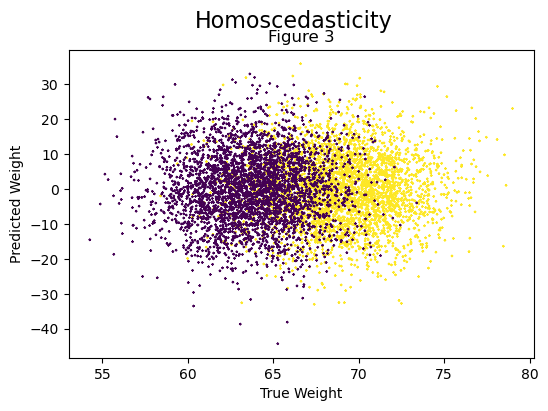

In [13]:
fig,ax1 = plt.subplots(1,1,figsize=(6,4), squeeze=True)
fig.suptitle("Homoscedasticity", fontsize=16)
ax1.scatter(x=df_train.Height, y=res.resid, c=df_train.Gender=='Male', s=1, marker='x')
ax1.set_title('Figure 3')
ax1.set_xlabel('True Weight')
ax1.set_ylabel('Predicted Weight')
plt.show()

**Conclusion** Breusch_Pagan F-statistic is very small and its p-value is > 0.05. So we fail to reject the null hypothesis that the residuals do NOT depend on x. 
The scatter plot also confirms thist in the absense of any pattens. Therefore no violation of this assumption

### 4.1.4 Serial Correlation:
A.K.A autocorrelation, when the residuals are correlated with one another. This is more of a problem in time series data.  
To dignose it we look at **Durbin-Watson** number from regression results DW = 2.014. Since it is in the range of (1.5, 2.5) then there is no serial correlation to worry about.

### 4.1.5 Normality of Error Terms:
If error terms are **NOT** normally distributed this cause create problems when t-testing the coefficients, because standard-error is no longer reliable. Which will also affect the confidence intervals of predictions.  
The easiest way to diagnose normlity is plot a histogram of residuals or a Q-Q plot (from `scipy.stats.probplot`). Many of the regression output adress the normality of $\epsilon$, like Omnibus, Skew, Kurtosis, Jarque-Bera (details at the end of this notebook)

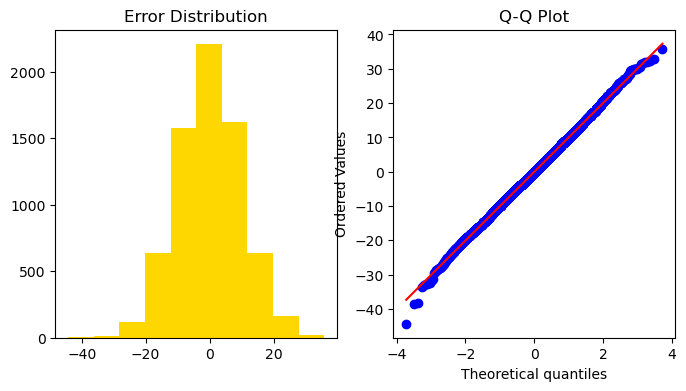

In [14]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.hist(res.resid, color='gold')
ax1.set_title('Error Distribution')
probplot(res.resid, plot=ax2)
ax2.set_title('Q-Q Plot');

**Conclusion** error terms appear to be normally distributed 
### 5.1 Prediction


In [15]:
y_test_pred = res.predict(exog=df_test)
test_rsquare= r2_score(df_test.Weight, y_test_pred)
print(f"Test R-squared:{test_rsquare:.3f} ")

Test R-squared:0.904 


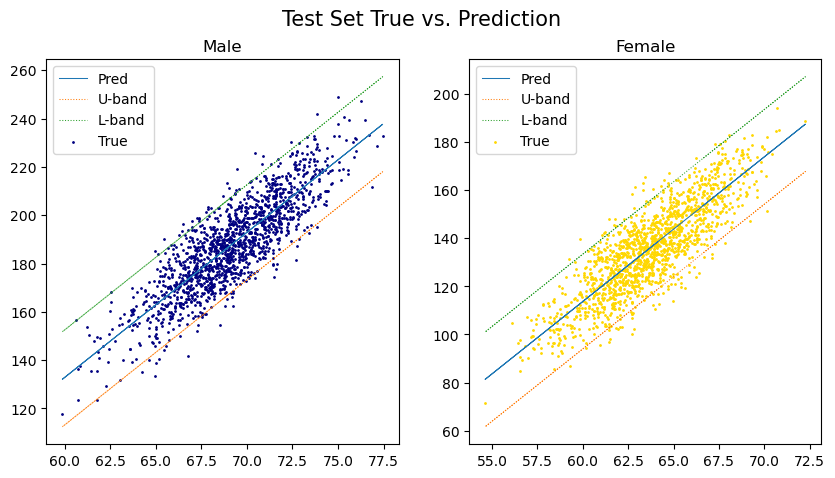

In [16]:
masks = {'Male':np.where(df_test.Gender=='Male', True, False),
        'Female': np.where(df_test.Gender=='Female', True, False)}
test_pred = res.get_prediction(df_test)
test_summary = test_pred.summary_frame()
labels = ['True','Pred','U-band','L-band']
colors = ['navy','gold']

fig,ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Test Set True vs. Prediction', fontsize=15)
for i,(title,mask) in enumerate(masks.items()):
    ax[i].scatter(df_test[mask].Height,df_test[mask].Weight, label=labels[0], color=colors[i],marker='o',s=1)
    ax[i].plot(df_test[mask].Height, test_summary[mask]['mean'],ls='-', label=labels[1],lw=0.75)
    ax[i].plot(df_test[mask].Height, test_summary[mask]['obs_ci_lower'], ls=':', label=labels[2],lw=0.75)
    ax[i].plot(df_test[mask].Height, test_summary[mask]['obs_ci_upper'], ls=':', label=labels[3],lw=0.75)
    ax[i].set_title(title)
    ax[i].legend()

# Appendex
Here's a quick definition of each of the regression output statistics and their use
#### 7.1 R-squared
R-squared/Adj.R-squared: 90.4% of variability in dependent variable can be explained by the independed variables. This is high enough for training set, but let's see how well the model deals with data it hasn't seen (test_set)
Test R-squared at 90.5% is as high as train R-squared, which means the model generalizes well


#### 7.2 F-statistic|Prob(F)
It tests how well the independent variables as a group explain the variations of the dependent variable (i.e. tests the null hypothesis $H_0: coef_1=coef_2=\dots coef_n=0$)   
P-value of F-statistic, or the probability of type I error (observation happenning giving the null hypothesis is true)  
In this case F-statistic is very large and Prob(F) is zero, which is great!  

#### 7.3 AIC:
The Akaike Information Criterion (AIC) measures overfit. It rewards the model for goodness-of-fit and penalize it if the model becomes overly complicated  
In this case AIC is large, which is good!  

#### 7.4 Omnibus/Prob(Omnibus):
Omnibus tests the skewness and kurtosis of the residuals.  
**closer to zero the better***  
Prob(Omnibus):tests the probability the residuals are normally distributed.  
**The closer to one the better***  

In this case Omnibus is relatively hight and the Prob (Omnibus) is relatively low so the data is far from normal. A linear regression approach would probably be better than random guessing but likely not as good as a nonlinear approach.  

#### 7.5 Skew 
Measures data symmetry. We want to see something close to zero, indicating the residual distribution is normal. Note that this value also drives the Omnibus.  
**The closer to zero the better***   

#### 7.6 Kurtosis
Measure of "peakiness", or curvature of the data. Higher peaks lead to greater Kurtosis. Greater Kurtosis can be interpreted as a tighter clustering of residuals around zero, implying a better model with few outliers.  
**The higher the better**  

#### 7.7 Durbin-Watson
Tests for serial correlation. We hope to have a value between 1.5 and 2.5. In this case, the data is close, but within limits.  

#### 7.8 Jarque-Bera (JB)/Prob(JB)
like the Omnibus test in that it tests both skew and kurtosis. We hope to see in this test a confirmation of the Omnibus test.   

#### 7.9 Condition Number
Measures the sensitivity of a function's output as compared to its input. When we have multicollinearity, we can expect much higher fluctuations to small changes in the data, hence, we hope to see a relatively small number, something below 30.  
**The smaller below 30 the better**


Good reading on regression violations and how to correct them:  
https://people.duke.edu/~rnau/testing.htm

#### 7.10 Outliers

The below code is another way to identify outliers using`statsmodels` library. It has many options to calculate them. That said, I still don't think there is a need to exclude any observation from this particular dataset

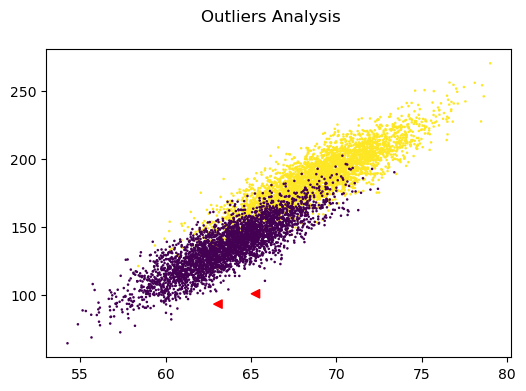

In [17]:
"""
Outlier detection methods:
- 'bonferroni` : one-step correction
- `sidak` : one-step correction
- `holm-sidak` :
- `holm` :
- `simes-hochberg` :
- `hommel` :
- `fdr_bh` : Benjamini/Hochberg
- `fdr_by` : Benjamini/Yekutieli
"""
outliers = res.outlier_test()
outidx = outliers[outliers.iloc[:,-1] < 0.99].index
outliers.loc[outidx]

fig= plt.figure(figsize=(6,4))
fig.suptitle('Outliers Analysis')
plt.scatter(df_train.Height, df_train.Weight, c=df_train.Gender.values=='Male', s=0.7)
plt.scatter(df_train.loc[outidx].Height, df_train.loc[outidx].Weight,
            c=df_train.loc[outidx].Gender.values=='Male', marker='<',cmap='flag');

In [18]:
masks = {'Male':np.where(df_test.Gender=='Male', True, False),
        'Female': np.where(df_test.Gender=='Female', True, False)}
test_pred = res.get_prediction(df_test)
test_summary = test_pred.summary_frame()
labels = ['True','Pred','U-band','L-band']


In [19]:
masks.items()

dict_items([('Male', array([ True, False,  True, ..., False, False,  True])), ('Female', array([False,  True, False, ...,  True,  True, False]))])